In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pathlib import Path
from read_roi import read_roi_zip
from collections import OrderedDict, Counter
import math
import PIL
from PIL import Image
from PIL.TiffTags import TAGS
import tkinter as tk
from tkinter import filedialog

# Read, format and save raw data from ROIs #

In [142]:
askdirectory = filedialog.askdirectory() # show an "Open" dialog box and return the path to the selected file
path = Path(askdirectory)
path

WindowsPath('D:/Sofia/2020-03-04_DCX-Tub')

In [172]:
tubulin = '[Tubulin] ' r'$(\mu M)$'
tub = 'tub'

DCXconc = '[DCX] ' r'$(\mu M)$'
DCX = 'DCX'

In [173]:
dateloc = str(path).find("2020")
date = str(path)[dateloc : dateloc+10]

folders = [x for x in path.iterdir() if x.is_dir()]
folders = [i for i in folders if (str(i)[-7:] == 'results') == True]

ch = []
conc_tub = []
conc_DCX = []
DCX_type = []

for i in folders:
    CHloc = str(i).find("CH")
    tubloc = str(i).rfind(tub)
    DCXloc = str(i).rfind(DCX)
    dcxtype = str(i).find("type")
    ch = ch + [str(i)[CHloc+2:CHloc+4]]
    conc_tub = conc_tub + [(str(i)[tubloc+3:tubloc+5])]
    conc_DCX = conc_DCX + [(str(i)[DCXloc+3:DCXloc+6])]
    DCX_type = DCX_type + [(str(i)[dcxtype+4:DCXloc-1])]

date,ch, conc_tub, conc_DCX, DCX_type

('2020-03-04',
 ['12', '13', '23'],
 ['07', '06', '07'],
 ['000', '000', '100'],
 ['None', 'None', 'WT'])

In [174]:
tub_conc =  [float(i) for i in conc_tub]
DCX_conc =  [float(i) for i in conc_DCX]
frame_analyzer = pd.read_csv(path/'frame_rates_avg.csv',sep=',')
pixel = 0.0633
folders

[WindowsPath('D:/Sofia/2020-03-04_DCX-Tub/CH12_Acros_tub07uM_typeNone_DCX000nM-results'),
 WindowsPath('D:/Sofia/2020-03-04_DCX-Tub/CH13_Acros_tub06uM_typeNone_DCX000nM-results'),
 WindowsPath('D:/Sofia/2020-03-04_DCX-Tub/CH23_Acros_tub07uM_typeWT_DCX100nM-results')]

In [175]:
#frame_analyzer = frame_analyzer.iloc[[1,3]].reset_index()
frame_analyzer

,Directory,Mean,SD,Frames,Outliers,MeanWOutliers,SDWOutliers
0,D:\Sofia\2020-03-04_DCX-Tub\CH12_Acros_tub07uM...,5.86,0.10,400,3,5.94,1.39
1,D:\Sofia\2020-03-04_DCX-Tub\CH13_Acros_tub06uM...,5.82,0.07,400,1,6.09,5.38
2,D:\Sofia\2020-03-04_DCX-Tub\CH23_Acros_tub07uM...,5.85,0.08,500,4,6.29,8.71


In [176]:
def open_roi_poly(k,name):
    roi_path = folders[k]/(name)

    roi_data = read_roi_zip(roi_path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','x3','y1','y2','y3'])
    for key in roi_data:
        roi_df = roi_df.append({'Track ID': roi_data[key]['name'],'x1': roi_data[key]['x'][0],'x2': roi_data[key]['x'][1],'x3': roi_data[key]['x'][2],'y1': roi_data[key]['y'][0],'y2': roi_data[key]['y'][1],'y3': roi_data[key]['y'][2]}, ignore_index=True)
    return roi_df

def open_roi_line(k,name):
    roi_path = folders[k]/(name)

    roi_data = read_roi_zip(roi_path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','y1','y2'])
    for key in roi_data:
        roi_df = roi_df.append({'Track ID': roi_data[key]['name'],'x1': roi_data[key]['x1'],'x2': roi_data[key]['x2'],'y1': roi_data[key]['y1'],'y2': roi_data[key]['y2']}, ignore_index=True)
    return roi_df

In [177]:
Length = 'Length ' r'$(\mu m)$'
Lifetime = 'Lifetime ' r'$(min)$'
GrowthRate = 'Growth Rate ' r'$(\mu m / min)$'
TimeToNucleate = 'Time to Nucleate ' r'$(min)$'
ShrinkageLength = 'Shrink Length ' r'$(\mu m)$'
ShrinkageLifetime = 'Shrink Lifetime ' r'$(min)$'
ShrinkageRate = 'Shrink Rate ' r'$(\mu m / min)$'
poly_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate)
line_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate,ShrinkageLength,ShrinkageLifetime,ShrinkageRate)

In [178]:
def poly_dynamics(k):
        
    data = open_roi_poly(k,'kymoslopes.zip')
    supp = open_roi_line(k,'start.zip')
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]-2
    
    suppn = len(supp)
    start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data)
    pre_df = {'Date': np.full((n), date),'CH': np.full((n), ch[k]),tubulin: np.full((n), tub_conc[k]),DCXconc: np.full((n), DCX_conc[k])}
    df = pd.DataFrame(pre_df) 
    
    df[Length] = abs((data['x2']-data['x1'])*pixel)
    
    data[Lifetime] = abs((data['y2']-data['y1'])*spf/60)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames-2 else np.NaN, axis=1)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x[Lifetime] != 0 else np.NaN, axis=1)
    
    df[GrowthRate] = df[Length]/df[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NAN )
    
    df[TimeToNucleate] = (data['y1']-start)*spf/60
    
    df[ShrinkageLength] = abs((data['x3']-data['x2'])*pixel)
    df[ShrinkageLifetime] = abs((data['y3']-data['y2'])*spf/60)
    df[ShrinkageLifetime] = df[ShrinkageLifetime].apply(lambda x: np.NAN if x == 0 else x)
    df[ShrinkageRate] = df[ShrinkageLength]/df[ShrinkageLifetime]
    
    df.loc[pd.isnull(df[GrowthRate]), [Length,Lifetime,TimeToNucleate,ShrinkageLength,ShrinkageLifetime,ShrinkageRate]] = np.NaN
    
    df['DCX Type'] = DCX_type[k]
        
    return df

def line_dynamics(k):
        
    data = open_roi_line(k,'kymoslopes.zip')
    #data_even = data.iloc[::2].reset_index()
    #data_odd = data.iloc[1::2].reset_index()
    data_even = data
    data_odd = data
    
    supp = open_roi_line(k,'start.zip')
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]-2
    
    suppn = len(supp)
    start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data_even)
    pre_df = {'Date': np.full((n), date),'CH': np.full((n), ch[k]),'Concentration ' r'$(\mu M)$': np.full((n), conc[k])}
    df = pd.DataFrame(pre_df) 
    
    data_even[Length] = abs((data_even['x2']-data_even['x1'])*pixel)
    data_even[Lifetime] = abs((data_even['y2']-data_even['y1'])*spf/60)
    df[GrowthRate] = data_even[Length]/data_even[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NaN )
    
    data[Lifetime] = abs((data_odd['y2']-data_odd['y1'])*spf/60)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames else np.NaN, axis=1)
    
    df[Length] = df[GrowthRate]*df[Lifetime]
    
    df[TimeToNucleate] = ((data_odd[['y1','y2']].min(axis=1))-start)*spf/60
    
    df.loc[pd.isnull(df[GrowthRate]), [Length,Lifetime,TimeToNucleate]] = np.NaN
    
    df = df[['Date','CH','Concentration ' r'$(\mu M)$',Length,Lifetime,GrowthRate,TimeToNucleate]]
        
    return df

In [179]:
path.parents[0]

WindowsPath('D:/Sofia')

In [180]:
newdirectory = str(path.parents[0])+'//Data_Sheets_methylcellulose'
newmydir = Path(newdirectory)
newmydir.mkdir(exist_ok=True)

In [181]:
df = poly_dynamics(0)
for i in range(1,len(ch)):
    df0 = poly_dynamics(i)
    df = df.append(df0, ignore_index=True)

df.to_csv(path/(date +'.csv'), encoding='utf-8', index=False)
df.to_csv(newmydir/(date+'.csv'), encoding='utf-8', index=False)
df

,Date,CH,[Tubulin] $(\mu M)$,[DCX] $(\mu M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,DCX Type
0,2020-03-04,12,7.0,0.0,1.7724,3.027667,0.585401,4.61475,1.7724,0.097667,18.1474,None
1,2020-03-04,12,7.0,0.0,3.8613,5.371667,0.718827,0.415083,3.9879,0.195333,20.4159,None
2,2020-03-04,12,7.0,0.0,1.6458,2.246333,0.732661,1.09875,1.7091,0.097667,17.4993,None
3,2020-03-04,12,7.0,0.0,2.532,4.199667,0.602905,0.80575,2.532,0.195333,12.9625,None
4,2020-03-04,12,7.0,0.0,2.9751,3.809000,0.781071,19.9484,2.9751,0.097667,30.4618,None
...,...,...,...,...,...,...,...,...,...,...,...,...
201,2020-03-04,23,7.0,100.0,6.7731,8.872500,0.763381,2.25469,2.0889,1.170000,1.78538,WT
202,2020-03-04,23,7.0,100.0,1.0128,1.267500,0.799053,6.93469,1.0128,0.585000,1.73128,WT
203,2020-03-04,23,7.0,100.0,8.862,15.892500,0.557622,0.499688,6.7098,2.437500,2.75274,WT
204,2020-03-04,23,7.0,100.0,4.4943,6.142500,0.731673,2.15719,0.8862,0.292500,3.02974,WT


In [182]:
dfmean = df.groupby('CH').mean()
#dfmean.to_csv(path/(date+'_0_mean.csv'), encoding='utf-8', index=False)
dfmean

,[Tubulin] $(\mu M)$,[DCX] $(\mu M)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Shrink Lifetime $(min)$
CH,,,,,
12,7.0,0.0,6.180905,0.659952,0.253084
13,6.0,0.0,5.384811,0.597618,0.187310
23,7.0,100.0,11.002727,0.698041,1.917500


In [67]:
df[['CH','Time to Nucleate $(min)$']].mean()

CH                          2.710027e+79
Time to Nucleate $(min)$    1.242096e+01
dtype: float64

In [14]:
dfstd = df.groupby('CH').std()
#dfstd.to_csv(path/(date+'_0_std.csv'), encoding='utf-8', index=False)
dfstd

,Concentration $(\mu M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$
CH,,,,,
11,0.0,2.032713,0.792113,1.020966,0.624537


In [49]:
files = [x for x in newmydir.iterdir() if x.is_file()]
files

[WindowsPath('D:/Sofia/2020-02-04_DIC_TUBcontrol/Data_Sheets/2020-02-04.csv')]

In [66]:
tubulin_data = pd.read_csv(files[0], encoding='utf-8')
for i in range(1,len(files)):
    t_data = pd.read_csv(files[i], encoding='utf-8')
    tubulin_data = tubulin_data.append(t_data, ignore_index=True)
tubulin_data.to_csv(newmydir/('MasterSheetSofia.csv'), encoding='utf-8', index=False)

# Preliminary plot Histograms #

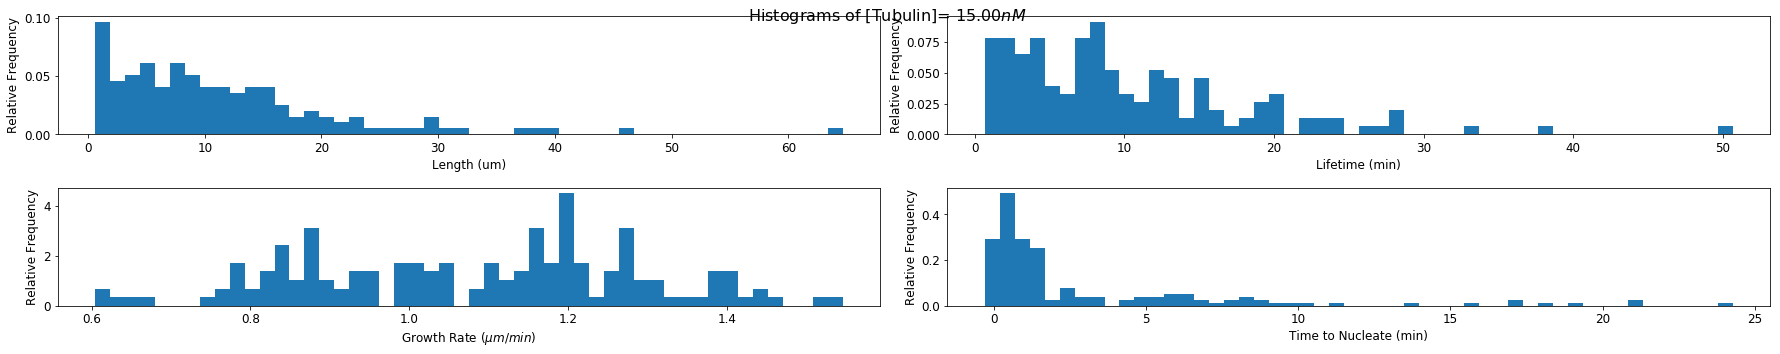

In [137]:
font = {'size'   : 12}
plt.rc('font', **font)

j=0
track = df[df['Concentration (uM)'] == df['Concentration (uM)'].unique()[j]]
titles = ('Growth','Nucleation','Catastrophe','Shrinkage')
xlables = ('Growth Rate ' r'$(\mu m / min)$','Time to Nucleate ' r'$(min)$','Lifetime ' r'$(min)$','Shrink Rate ' r'$(\mu m / min)$')

plt.figure(figsize=(25,5))
for i in track.columns[3:]:
    n = df.columns.get_loc(i)
    plt.subplot(2,2,n-2)
    plt.hist(track[i],50, density=True)
    plt.ylabel('Relative Frequency')
    plt.xlabel(i)
    #plt.title(titles[i]);

plt.suptitle('Histograms of '+variable+'= %.2f' r'$n M$'%(conc[j]), fontsize=16)
plt.tight_layout()
#plt.savefig(path/(date+'_histograms.png'))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


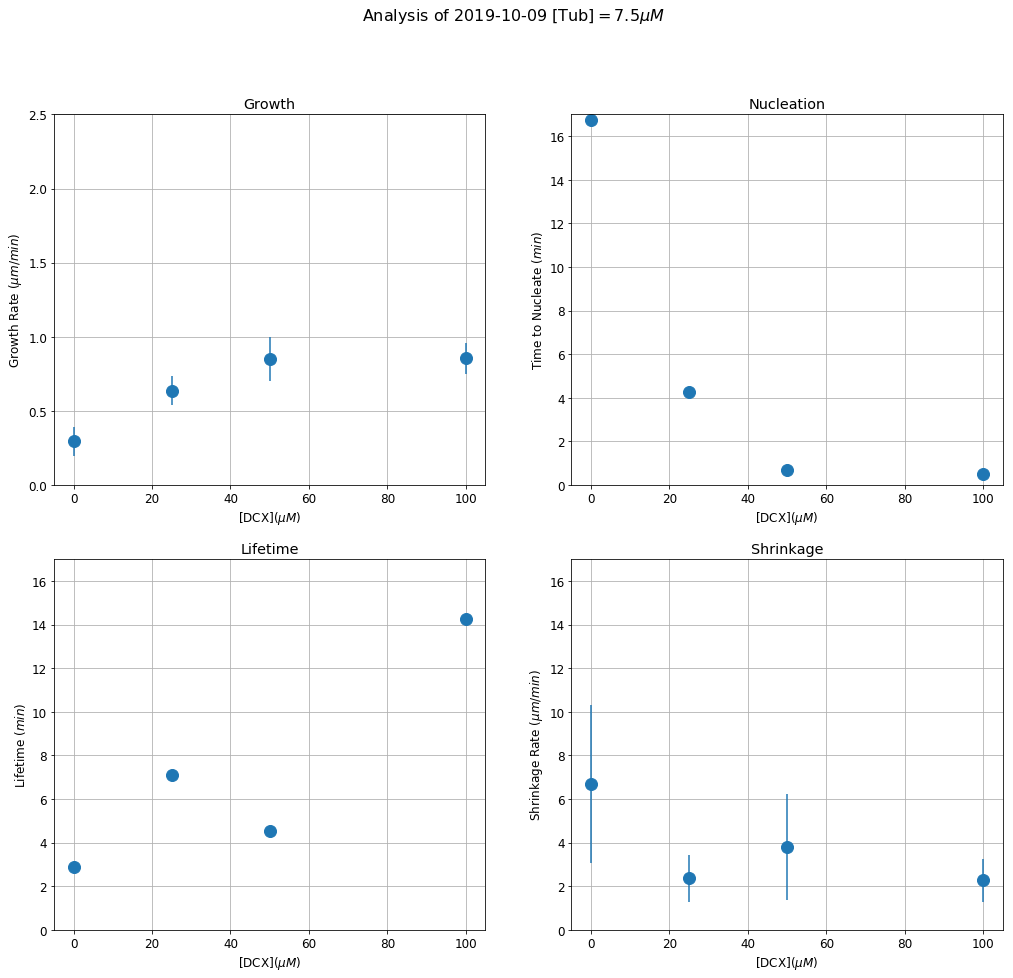

In [145]:
titles = ('Growth','Nucleation','Lifetime','Shrinkage')
ylables = ('Growth Rate ' r'$(\mu m / min)$','Time to Nucleate ' r'$(min)$','Lifetime ' r'$(min)$','Shrinkage Rate ' r'$(\mu m / min)$')
scattersize = 12
#a1 , a0 = np.polyfit(data['dcx conc'], data['growth mean'], 1)
#y_int = -a0/a1
#x_range = np.arange(0,105,0.1)

fig, ax = plt.subplots(2,2,figsize=(17,15))

plt.suptitle('Analysis of '+date+' [Tub]' r'$= 7.5 \mu M$', fontsize=16)

plt.subplot(2,2,1)
plt.errorbar(data[variable], data['growth mean'], yerr=data['growth std'], fmt='o',markersize=scattersize)
#plt.plot(x_range, a1*x_range+a0)
plt.ylim(0,2.5)
plt.xlim(-5,105)
#plt.legend('Data')
#plt.legend(('Linear Fit:  'r'$K_a$'' = %.2f 'r'$\frac{dimers}{\mu M \; s}$'', 'r'$C_c$'' = %.2f 'r'$\mu M$' %(a1*27.1, y_int),'Data'),loc='upper left')

plt.subplot(2,2,2)
plt.errorbar(data[variable], data['time2nuc mean'], fmt='o',markersize=scattersize)
#plt.scatter(data['tub conc'], data['time2nuc std'])
plt.ylim(0,17)
plt.xlim(-5,105)
#plt.legend(( 'Mean',r'$\sigma$'),loc='upper right')

plt.subplot(2,2,3)
plt.errorbar(data[variable], data['lifetime mean'], fmt='o',markersize=scattersize)
#plt.scatter(data['tub conc'], data['lifetime std'])
plt.ylim(0,17)
plt.xlim(-5,105)
#plt.legend(('Mean', r'$\sigma$'),loc='upper left')

plt.subplot(2,2,4)
plt.errorbar(data[variable], data['shrinkage mean'] , yerr=data['shrinkage std'], fmt='o',markersize=scattersize)
plt.ylim(0,17)
plt.xlim(-5,105)
#plt.legend(('Mean', r'$\sigma$'),loc='upper left')


for i in [0,1,2,3] :
    plt.subplot(2,2,i+1)
    plt.xlabel(variable + r'$(\mu M)$')
    plt.ylabel(ylables[i])
    plt.title(titles[i]);
    
    plt.grid(True)
#plt.xlabel('Lifetime ' r'$(min)$')    
plt.savefig(path/(date+'_graphs.pdf'))
plt.savefig(path/(date+'_graphs.png'))

In [130]:
def no_nuc_count(k):
    
    #filename = path/('CH'+ch[k]+'_'+conc_name[k]+'uM-results')/(date+'_CH'+ch[k]+'_'+conc_name[k]+'uM.csv')
    
    data = open_roi_poly(k,'kymoslopes.zip')
    
    ####################################
    
    #evenID = [n-1 for n in np.arange(0, len(data)) if n%2]
    
    inter = t_interval[k];
    length = abs((data['x2']-data['x1'])*pixel)
    duration = abs((data['y2']-data['y1'])*inter)
    speed = length/duration*60;
    
    no_nuc = 0
    
    for i in np.arange(0, len(data)):
        g = speed[i]
        
        if g > 5:
            no_nuc = no_nuc+1
    
    r = {variable:[conc[k]],'No Nuc':[no_nuc],'Total Seeds':[len(data)],'Percent No Nuc':[no_nuc/len(data)*100]}
    results0 = pd.DataFrame(data=r)            
       
    ####################################      
        
    return results0

In [131]:
no_nuc = no_nuc_count(0)


for i in range(1,len(ch)): 
    no_nuc0 = no_nuc_count(i)
    no_nuc = pd.concat([no_nuc, no_nuc0], sort=False)
    
no_nuc = no_nuc.sort_values(by=[variable])
no_nuc.to_csv(path/(date+'_no_nuc.csv'), encoding='utf-8', index=False)
no_nuc

NameError: name 'inter' is not defined

In [148]:
def rescue_count(k):
    
    #filename = path/('CH'+ch[k]+'_'+conc_name[k]+'uM-results')/(date+'_CH'+ch[k]+'_'+conc_name[k]+'uM.csv')
    
    data = open_roi_poly(k,'kymoslopes.zip')
    
    ####################################
    
    #evenID = [n-1 for n in np.arange(0, len(data)) if n%2]
    
    inter = t_interval[k];
    length = abs((data['x2']-data['x1'])*pixel)
    duration = abs((data['y2']-data['y1'])*inter)
    speed = length/duration*60;
    
    diff = abs((data['x3']-data['x1'])*pixel)
    
    rescue = 0
    cat = 0
    
    for i in np.arange(0, len(data)):
        g = speed[i]
        
        if g < 5:
            cat = cat +1
            
            if  diff[i] > 0.320 :
                rescue = rescue+1
    
    r = {variable:[conc[k]],'Rescues':[rescue],'Total Catastrophes':[cat],'Percent Rescue':[rescue/cat*100]}
    results0 = pd.DataFrame(data=r)            
       
    ####################################      
        
    return results0

In [149]:
rescue = rescue_count(0)


for i in range(1,len(ch)): 
    rescue0 = rescue_count(i)
    rescue = pd.concat([rescue, rescue0], sort=False)
    
rescue = rescue.sort_values(by=[variable])
rescue.to_csv(path/(date+'_rescue.csv'), encoding='utf-8', index=False)
rescue

,[DCX],Rescues,Total Catastrophes,Percent Rescue
0,0.0,0,70,0.000000
0,25.0,67,136,49.264706
0,50.0,21,79,26.582278
0,100.0,89,89,100.000000


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


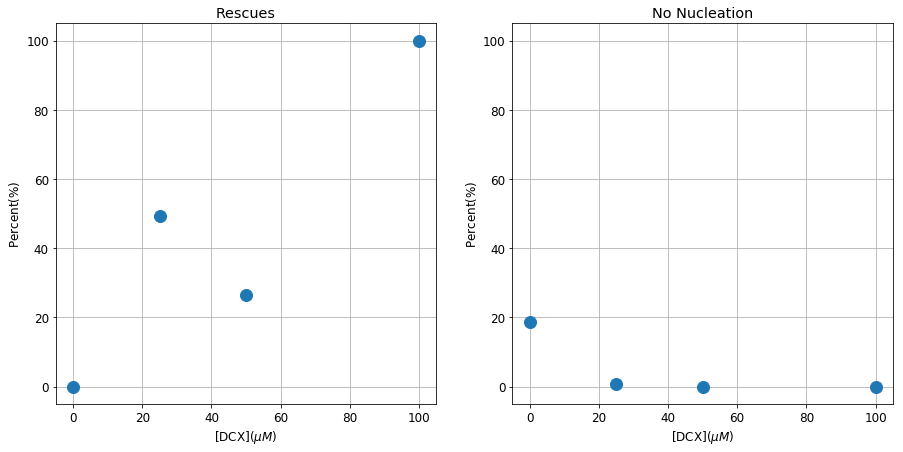

In [150]:
titles = ('Rescues','No Nucleation')
ylables = ('Percent' r'$(\%)$','Percent' r'$(\%)$')
scattersize = 12


plt.figure(figsize=(15,7))
#plt.suptitle('Analysis of '+date+'[Tub]' r'$= 7.5 \mu M$', fontsize=16)

plt.subplot(1,2,1)
plt.errorbar(rescue[variable], rescue['Percent Rescue'], fmt='o',markersize=scattersize)
#plt.plot(x_range, a1*x_range+a0)
plt.ylim(-5,105)
plt.xlim(-5,105)

plt.subplot(1,2,2)
plt.errorbar(no_nuc[variable], no_nuc['Percent No Nuc'], fmt='o',markersize=scattersize)
#plt.scatter(data['tub conc'], data['time2nuc std'])
plt.ylim(0-5,105)
plt.xlim(-5,105)
#plt.legend(( 'Mean',r'$\sigma$'),loc='upper right')


for i in [0,1] :
    plt.subplot(1,2,i+1)
    plt.xlabel(variable +  r'$(\mu M)$')
    plt.ylabel(ylables[i])
    plt.title(titles[i]);
    
    plt.grid(True)
#plt.xlabel('Lifetime ' r'$(min)$')    
plt.savefig(path/(date+'_graphs_rescue.pdf'))
plt.savefig(path/(date+'_graphs_rescue.png'))